# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import torch
import torch.nn.functional as F
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [6]:
import tiny_imagenet
tiny_imagenet.download(".")

./tiny-imagenet-200 already exists, not downloading


Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [7]:
f_wnids = open('tiny-imagenet-200/wnids.txt', 'r').readlines()
labels = set([x[:-1] for x in f_wnids])
train_images = {i: glob.glob('tiny-imagenet-200/train/' + str(label) + '/images/*') for i, label in enumerate(labels)}
val_images = {i: glob.glob('tiny-imagenet-200/val/' + str(label) + '/*') for i, label in enumerate(labels)}

class CustomDataset(Dataset):
    def __init__(self, root_dir='tiny-imagenet-200/', mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            self.images_per_class = 500
        elif self.mode == 'val':
            self.images_per_class = 50
        self.num_classes = 200

    def __getitem__(self, idx):
        class_idx = idx // self.images_per_class
        image_idx = idx % self.images_per_class

        if self.mode == 'train':
            img = Image.open(train_images[class_idx][image_idx])
        elif self.mode == 'val':
            img = Image.open(val_images[class_idx][image_idx])

        if self.transform:
            img = self.transform(img)
            if img.shape[0] == 1:
                img = torch.cat((img, img, img), dim=0)
        else:
            img = np.array(img) / 255
            if img.ndim == 2:
                img = img[np.newaxis, :]
                img = np.concatenate((img, img, img), axis=0)
            else:
                img = img.transpose((2, 0, 1))
            img = torch.tensor(img, dtype=torch.float32)
        y = class_idx
        return img, torch.tensor(y)
    
    def __len__(self):
        return self.images_per_class * self.num_classes

batch_size = 256
epochs_n = 40 

data_transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ])}

dataset_train = CustomDataset(mode='train', transform=data_transform['train'])
dataset_val = CustomDataset(mode='val', transform=data_transform['val'])
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

def train(model, optimizer, PATH, epochs_n=20, batch_size=512):
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        train_accuracy_curve[epoch] = 0
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            
            labels_pred = prediction.argmax(dim=-1, keepdim=True).view(-1)
            train_accuracy_curve[epoch] += labels_pred.eq(y).sum().item() / len(y)
            
            loss = criterion(prediction, y)
            train_loss_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        train_accuracy_curve[epoch] /= n_batches_train

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        train_loss_curve[epoch] /= n_batches_train
        axes[0].plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        val_accuracy_curve[epoch] = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            
            labels_pred = prediction.argmax(dim=-1, keepdim=True).view(-1)
            val_accuracy_curve[epoch] += labels_pred.eq(y).sum().item() / len(y)

            loss = criterion(prediction, y)
            val_loss_curve[epoch] += loss.item()
        
        val_accuracy_curve[epoch] /= n_batches_val
        val_loss_curve[epoch] /= n_batches_val
        axes[0].plot(val_loss_curve, label='val')
        axes[0].set_title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        axes[0].legend()
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            torch.save(model.state_dict(), PATH)
        
        axes[1].set_title('Accuracy: train {:.4f}, val {:.4f}'.format(train_accuracy_curve[epoch], val_accuracy))
        axes[1].plot(train_accuracy_curve, label='train')
        axes[1].plot(val_accuracy_curve, label='val')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

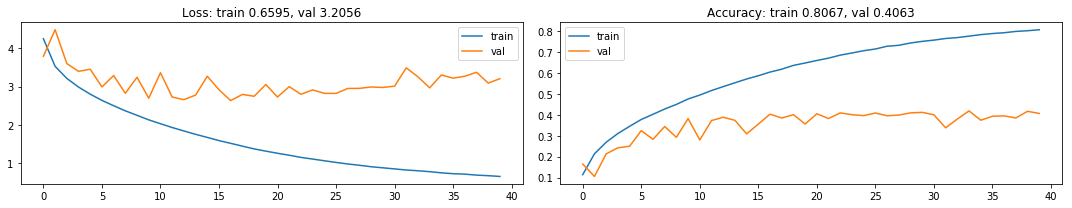

100%|██████████| 40/40 [30:01<00:00, 45.02s/it]


BlacKitteNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size

In [8]:
class BlacKitteNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 200)
        )

    def forward(self, input):
        out = self.feature_extractor(input)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return F.log_softmax(out, dim=-1)
    
model = BlacKitteNet().to(device)
criterion = F.nll_loss
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

PATH = 'models/BlacKitteNet.pt'
set_random_seeds(device=device)
train(model, opt, PATH=PATH, epochs_n=epochs_n, batch_size=batch_size)
model.load_state_dict(torch.load(PATH))
model.eval()

When everything is done, please compute accuracy on the validation set and report it below.

In [9]:
correct = 0
for x, y in val_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)

    labels_pred = prediction.argmax(dim=-1, keepdim=True).view(-1)
    correct += labels_pred.eq(y).sum().item() / len(y)
val_accuracy = correct / len(val_loader)
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))

Validation accuracy: 41.88%


# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

1. For this task, I adapted my code for the second homework in Machine Learning course, where we also were asked to construct a CNN model in `pytorch`. However, when I just added it, it didn't reach 40% on the validation set. I used ELU function, so I changed it to ReLU and faced a slight improvement. What helped me next was adding one more convolutional layer and one more fully-connected layer before the last one. Finally, adding augmentation transforms helped to get the desired accuracy.

2. The final architecture is a sequence of blocks Conv-BN-ReLU-MaxPool which is a pretty standard pipeline. Next, there is an aggregating block of Dropout-Dense-BN-ReLU, followed by the classifying dense layer with Log-Softmax.

3. I took batch size 256 - the number seems to be neither too big nor too small for the training set of 100k samples and is a pretty standard one. Optimization algorithm is RMSprop with a learning rate 0.001 - the default one 0.01 showed itself not so good in the experiments. The number of epochs is 40, however, I saved only the weights which achieved the best quality on the validation set.

4.

* Dropout 0.4 between the convolutional and fully-connected parts - helped not to overfit too fast.

* BN - gave a nice boost in accuracy and training time.

* data augmentation - also helped to achieve better quality on the validation set.